In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random, device_put

import numpy as np
import matplotlib.pyplot as plt

from pathgradient import *

2023-11-16 10:16:37.445710: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [3]:
# Jit and vectorize the functions

jax_cdf_differential_decay_width_jit = jit(jax_cdf_differential_decay_width)
jax_cdf_norm_jit = jit(jax_cdf_norm)

jax_cdf_differential_decay_width_vmap_final_energy = vmap(jax_cdf_differential_decay_width_jit, in_axes=(0, None, None, None, None), out_axes=0)
jax_cdf_differential_decay_width_vmap = vmap(jax_cdf_differential_decay_width_vmap_final_energy, in_axes=(None, 0, None, None, None), out_axes=1)
jax_cdf_norm_vmap = vmap(jax_cdf_norm_jit, in_axes=(0, None, None), out_axes=0)

In [44]:
# Get the gradients
grad_cdf_differential_decay_width = grad(jax_cdf_differential_decay_width, argnums=(0, 4))

grad_x_cdf_differential_decay_width = grad(jax_cdf_differential_decay_width, argnums=(0))
grad_theta_cdf_differential_decay_width = grad(jax_cdf_differential_decay_width, argnums=(4))
grad2_xtheta_cdf_differential_decay_width = grad(grad_x_cdf_differential_decay_width, argnums=(4))
grad2_thetatheta_cdf_differential_decay_width = grad(grad_theta_cdf_differential_decay_width, argnums=(4))

grad_cdf_norm = grad(jax_cdf_norm, argnums=(0, 2))
grad_total_decay_width_to_discrete = grad(jax_total_decay_width_to_discrete, argnums=(0))

grad_continuum_cut = grad(jax_continuum_cut, argnums=(3))
grad2_continuum_cut = grad(grad_continuum_cut, argnums=(3))
grad3_continuum_cut = grad(grad2_continuum_cut, argnums=(3))

# cdf_norm = jax_cdf_norm(23.0, DISCRETE_CONTINUUM_BOUNDARY, 0.01)
# print(cdf_norm, "cdf_norm")

# Define the gradient calculator for \nabla_{\theta}
def grad_theta_x(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter):
    # gradv = grad_cdf_differential_decay_width(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
    # grad_x_cdf = gradv[0] # --> this is just the PDF!
    # grad_theta_cdf = gradv[1]

    grad_x_cdf = grad_x_cdf_differential_decay_width(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
    grad_theta_cdf = grad_theta_cdf_differential_decay_width(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)

    # We DON'T need to correct for the "spicy" factor in the inverse CDF. (It cancels out in the division.)
    #continuum_cut = jax_continuum_cut(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
    #print(continuum_cut, "continuum_cut")
    # The correction is added in the proper value of the CDF (TODO: add to the PDF as well?)

    grad_theta_x_val = - grad_theta_cdf / grad_x_cdf

    return grad_theta_x_val

grad2_theta_x = grad(grad_theta_x, argnums=(4))
grad3_theta_x = grad(grad2_theta_x, argnums=(4))

def grad2_theta_x_explicit(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter):
    grad_x_cdf = grad_x_cdf_differential_decay_width(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
    grad_theta_cdf = grad_theta_cdf_differential_decay_width(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
    grad2_xtheta_cdf = grad2_xtheta_cdf_differential_decay_width(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
    grad2_thetatheta_cdf = grad2_thetatheta_cdf_differential_decay_width(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)

    return - ( grad2_thetatheta_cdf / grad_x_cdf - (grad_theta_cdf * grad2_xtheta_cdf) / (grad_x_cdf * grad_x_cdf) )

grad_3_theta_x_explicit = grad(grad2_theta_x_explicit, argnums=(4))



In [46]:
# "Explicit" derivative test
initial_energy = 23.0
final_energy = 15.0
discrete_energies = DISCRETE_ENERGIES
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY
disp_parameter = 0.01

grad2_theta_x_val = grad2_theta_x(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter) 
grad2_theta_x_explicit_val = grad2_theta_x_explicit(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)

print(grad2_theta_x_val, grad2_theta_x_explicit_val)

grad_3_theta_x_explicit_val = grad_3_theta_x_explicit(final_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
print(grad_3_theta_x_explicit_val)

14786.3 14786.299
-3084843.0


In [15]:
# Finite differences test
initial_energy = 23.0
discrete_energies = DISCRETE_ENERGIES
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY
disp_parameter = 0.01

epsilon = 1e-5

# Sample an event
r = 0.4
next_energy, continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, discrete_energies,
                                                    discrete_continuum_boundary,
                                                    disp_parameter)

# Sample other close events
next_energy_plus, continuum_cut_plus = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, discrete_energies,
                                                    discrete_continuum_boundary,
                                                    disp_parameter + epsilon)

next_energy_minus, continuum_cut_minus = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, discrete_energies,
                                                    discrete_continuum_boundary,
                                                    disp_parameter - epsilon)


# Calculate the gradient with finite differences and with the analytical jax gradient
grad_theta_x_fd = (next_energy_plus - next_energy_minus) / (2 * epsilon)
grad_theta_x_jx = grad_theta_x(next_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)

print(grad_theta_x_fd, grad_theta_x_jx, "chirp")


-148.56031674437276 -148.57301 chirp


In [32]:
start_energy = 23.0
final_energy = 15.0
disp_parameter = 0.01
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY
discrete_energies = DISCRETE_ENERGIES
cdf_norm = jax_cdf_norm_vmap(jnp.array([start_energy]), discrete_continuum_boundary, disp_parameter)[0]
#print(cdf_norm)

cdf = jax_cdf_differential_decay_width_vmap(jnp.array([final_energy]), jnp.array([start_energy]), discrete_energies, discrete_continuum_boundary, disp_parameter)
print(cdf[0,0])

gradv = grad_theta_x(final_energy, start_energy, DISCRETE_ENERGIES, discrete_continuum_boundary, disp_parameter)
#gradv2 = grad2_theta_x(final_energy, start_energy, DISCRETE_ENERGIES, discrete_continuum_boundary, disp_parameter)
gradv3 = grad3_theta_x(final_energy, start_energy, DISCRETE_ENERGIES, discrete_continuum_boundary, disp_parameter)

print(gradv, gradv2, gradv3)

0.8749585
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "<frozen runpy>", line 173, in _run_module_as_main
  File "<frozen runpy>", line 65, in _run_code
  File "/Users/pbarham/jax-metal/lib/python3.11/site-packages/ipykernel_launcher.py", line 0, in <module>
  File "/Users/pbarham/jax-metal/lib/python3.11/site-packages/traitlets/config/application.py", line 1045, in launch_instance
    @classmethod
    
  File "/Users/pbarham/jax-metal/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 717, in start
    def start(self):
    
  File "/Users/pbarham/jax-metal/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 194, in start
    def start(self) -> None:
    
  File "/Users/pbarham/miniforge3/envs/diff/lib/python3.11/asyncio/base_events.py", line 593, in run_forever
    def run_forever(self):
    
  File "/Users/pbarham/miniforge3/envs/diff/lib/python3.11/asyncio/base_events.py", line 1845, in _run_once
    def _run_once(self):
    
  File "/Users/pbarham/miniforge3/envs/diff/lib/py

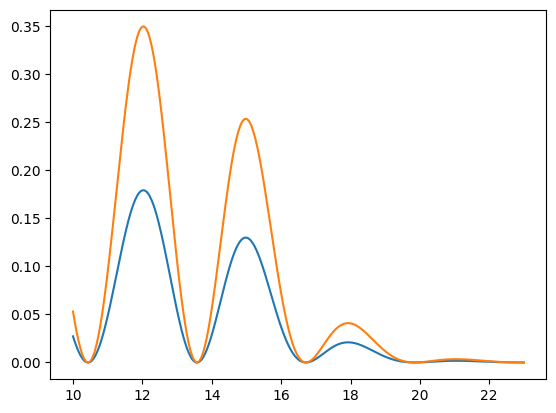

In [18]:
final_energies = jnp.linspace(10.0, 23.0, 500)

grads = []
cdfs = []

for i, ef in enumerate(final_energies):
    cdf = jax_cdf_differential_decay_width_vmap(jnp.array([ef]), jnp.array([start_energy]), discrete_energies, discrete_continuum_boundary, disp_parameter)
    gradv = grad_cdf_differential_decay_width(ef, start_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)[0]
    
    grads.append(gradv)
    cdfs.append(cdf[0,0])

plt.plot(final_energies, grads)

ddw_norm = jnp.trapz(differential_decay_width(final_energies, start_energy, discrete_continuum_boundary, disp_parameter), final_energies)
plt.plot(final_energies, differential_decay_width(final_energies, start_energy, discrete_continuum_boundary, disp_parameter)/ddw_norm)

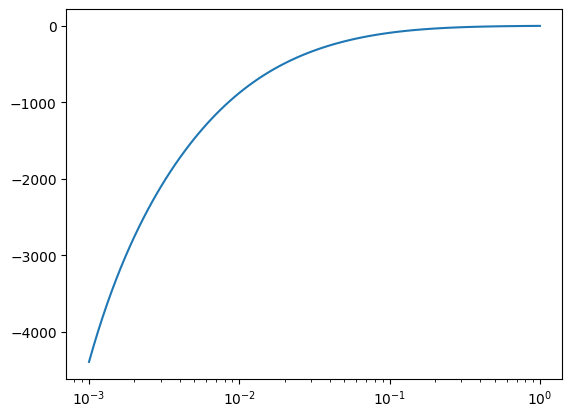

In [19]:
disp_parameters = jnp.logspace(-3, 0, 100)
start_energy = 23.0
final_energy = 18.0

grads = []
grads_theta = []
grads_x = []
cdfs = []

for i, dp in enumerate(disp_parameters):
    cdf = jax_cdf_differential_decay_width_vmap(jnp.array([final_energy]), jnp.array([start_energy]), discrete_energies, discrete_continuum_boundary, dp)
    #grad = grad_cdf_differential_decay_width(cdf_norm, ef, start_energy, discrete_continuum_boundary, dp)[1]
    gradv = grad_theta_x(final_energy, start_energy, discrete_energies, discrete_continuum_boundary, dp)

    grad_x, grad_theta = grad_cdf_differential_decay_width(final_energy, start_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
    
    grads.append(gradv)
    grads_x.append(grad_x)
    grads_theta.append(grad_theta)

    cdfs.append(cdf[0,0])

plt.plot(disp_parameters, grads)
#plt.plot(disp_parameters, grads_x)
plt.xscale('log')
#plt.yscale('log')

In [20]:
def continuum_circuit(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter):
    energy_path = [initial_energy]
    continuum_cuts = []
    prev_energy = initial_energy

    while True:
        # Sample the next energy
        r = np.random.rand()
        next_energy, continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                                r, prev_energy, discrete_energies,
                                                                discrete_continuum_boundary,
                                                                disp_parameter)
        
        continuum_cuts.append(continuum_cut)

        if next_energy < 0:
            break

        energy_path.append(next_energy)
        prev_energy = next_energy

    return energy_path, continuum_cuts


In [21]:
discrete_energies = DISCRETE_ENERGIES
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY

continuum_energy_path, continuum_cuts = continuum_circuit(23.0, discrete_energies, discrete_continuum_boundary, 0.01)

print(continuum_energy_path)
print(continuum_cuts)

[23.0, 15.144446670532805, 13.763754391836876, 11.742841695429803]
[Array(0.5125063, dtype=float32), Array(0.51661617, dtype=float32), Array(0.35462388, dtype=float32), Array(0.2345524, dtype=float32)]


Text(0.05, 23.0, 'E$_i$')

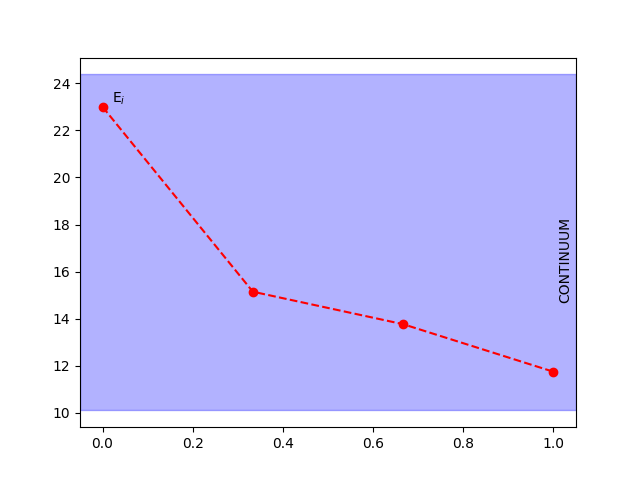

In [22]:
%matplotlib widget
plt.figure()
# Plot the continuum energy range (from discrete/continuum boundary to start energy) as a rectangle
plt.axhspan(discrete_continuum_boundary * 1.01, start_energy * 1.06, alpha=0.3, color='blue')
# Add a "CONTINUUM" label to the right, rotated 90 degrees
plt.text(1.01, (discrete_continuum_boundary + start_energy)/2, 'CONTINUUM', rotation=90, verticalalignment='center', horizontalalignment='left')

# Plot the continuum energy path as a scatter joined with dashed lines
plt.plot(np.linspace(0, 1, len(continuum_energy_path)), continuum_energy_path, color='red', linestyle='--', marker='o')

# Add a label for the initial energy
plt.text(0.05, start_energy, r'E$_i$', verticalalignment='bottom', horizontalalignment='right')

In [48]:
# Let's try and "move" an event
initial_energy = 23.0
discrete_energies = DISCRETE_ENERGIES
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY
disp_parameter = 0.01

epsilon = 10e-4

# Sample an event and compute the gradients w.r.t. the disp_parameter
r = 0.4
next_energy, continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, discrete_energies,
                                                    discrete_continuum_boundary,
                                                    disp_parameter)
print("Original")
print(next_energy, continuum_cut)

#cdf_norm = jax_cdf_norm(initial_energy, discrete_continuum_boundary, disp_parameter)
grad_thx = grad_theta_x(next_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
grad2_thx = grad2_theta_x(next_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
grad_cb = grad_continuum_cut(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
grad2_cb = grad2_continuum_cut(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
print(grad_thx, grad_cb)

# "Move the event" by epsilon
moved_disp_parameter = disp_parameter + epsilon
moved_energy = next_energy + epsilon * grad_thx + 1/2 * epsilon**2 * grad2_thx
moved_continuum_cut = continuum_cut + epsilon * grad_cb + 1/2 * epsilon**2 * grad2_cb
print("Moved")
print(moved_energy, moved_continuum_cut)

# Now sample the event again at the new value of the disp_parameter
recomp_energy, recomp_continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, discrete_energies,
                                                    discrete_continuum_boundary,
                                                    moved_disp_parameter)
print("Recomputed")
print(recomp_energy, recomp_continuum_cut)

Original
15.168338177118141 0.5125063
-148.57301 17.705313
Moved
15.027585 0.5292415
Recomputed
15.030922128588811 0.52929765


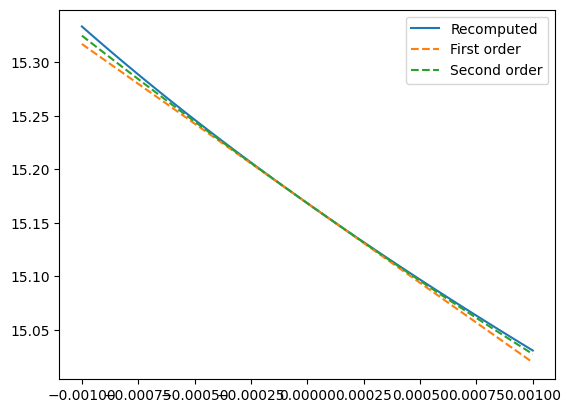

In [6]:
# Let's try and "move" an event
initial_energy = 23.0
discrete_energies = DISCRETE_ENERGIES
discrete_continuum_boundary = DISCRETE_CONTINUUM_BOUNDARY
disp_parameter = 0.01

epsilons = np.linspace(-0.001, 0.001, 50)

moved_energies_1 = []
moved_continuum_cuts_1 = []
moved_energies_2 = []
moved_continuum_cuts_2 = []
moved_energies_3 = []
moved_continuum_cuts_3 = []

recomputed_energies = []
recomputed_continuum_cuts = []

# Sample an event and compute the gradients w.r.t. the disp_parameter
r = 0.4

# Sample energy and compute gradients
next_energy, continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                    r, initial_energy, discrete_energies,
                                                    discrete_continuum_boundary,
                                                    disp_parameter)

grad_thx = grad_theta_x(next_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
grad2_thx = grad2_theta_x(next_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
#grad3_thx = grad3_theta_x(next_energy, initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
grad_cb = grad_continuum_cut(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
grad2_cb = grad2_continuum_cut(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)
#grad3_cb = grad3_continuum_cut(initial_energy, discrete_energies, discrete_continuum_boundary, disp_parameter)

for epsilon in epsilons:
    # "Move the event" by epsilon
    moved_disp_parameter = disp_parameter + epsilon
    moved_energy_1 = next_energy + epsilon * grad_thx
    moved_continuum_cut_1 = continuum_cut + epsilon * grad_cb
    moved_energy_2 = moved_energy_1 + 1/2 * epsilon**2 * grad2_thx
    moved_continuum_cut_2 = moved_continuum_cut_1 + epsilon * grad_cb + 1/2 * epsilon**2 * grad2_cb
    # moved_energy_3 = moved_energy_2 + 1/6 * epsilon**3 * grad3_thx
    # moved_continuum_cut_3 = moved_continuum_cut_2 + 1/6 * epsilon**3 * grad3_cb


    moved_energies_1.append(moved_energy_1)
    moved_continuum_cuts_1.append(moved_continuum_cut_1)
    moved_energies_2.append(moved_energy_2)
    moved_continuum_cuts_2.append(moved_continuum_cut_2)

    # Now sample the event again at the new value of the disp_parameter
    recomp_energy, recomp_continuum_cut = spicy_inverse_cdf_differential_decay_width(
                                                        r, initial_energy, discrete_energies,
                                                        discrete_continuum_boundary,
                                                        moved_disp_parameter)

    recomputed_energies.append(recomp_energy)
    recomputed_continuum_cuts.append(recomp_continuum_cut)


plt.figure()
plt.plot(epsilons, recomputed_energies, label='Recomputed')
plt.plot(epsilons, moved_energies_1, linestyle='--', label='First order')
plt.plot(epsilons, moved_energies_2, linestyle='--', label='Second order')
plt.legend()

plt.figure()
# Plot the relative errors 
plt.plot(epsilons, (recomputed_energies - moved_energies_1)/recomputed_energies, linestyle='--', label='First order')
plt.plot(epsilons, (recomputed_energies - moved_energies_2)/recomputed_energies, linestyle='--', label='Second order')
plt.legend()
